In [164]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.metrics import f1_score, roc_auc_score, recall_score, confusion_matrix
from keras.callbacks import ModelCheckpoint

In [184]:
with open('fixed_sequences_length_9_PELM/Group_Phos_S_neg.fasta', 'r') as f:
    s_negatif_txt = f.readlines()

s_negatif = np.array([])
for i in range(1,len(s_negatif_txt),2):
    temp = s_negatif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    s_negatif = np.append(s_negatif, temp2)

sequenceL = int(len(s_negatif)/9)
s_negatif_new = np.expand_dims(s_negatif, axis=0)
s_negatif_new = s_negatif_new.reshape(sequenceL,9)
labelneg = np.zeros((sequenceL,), dtype=int)
s_negatif_label = np.expand_dims(labelneg, axis=0)
s_negatif_label = s_negatif_label.reshape(sequenceL,1)
print(s_negatif_new.shape)
print(s_negatif_label.shape)


(1543, 9)
(1543, 1)


In [185]:
with open('fixed_sequences_length_9_PELM/Group_Phos_S_pos.fasta', 'r') as f:
    s_positif_txt = f.readlines()

s_positif = np.array([])
for i in range(1,len(s_positif_txt),2):
    temp = s_positif_txt[i]
    temp1 = temp[0:9]
    temp2 = list(temp1)
    s_positif = np.append(s_positif, temp2)

sequenceL = int(len(s_positif)/9)
s_positif_new = np.expand_dims(s_positif, axis=0)
s_positif_new = s_positif_new.reshape(sequenceL,9)
labelpos = np.ones((sequenceL,), dtype=int)
s_positif_label = np.expand_dims(labelpos, axis=0)
s_positif_label = s_positif_label.reshape(sequenceL,1)
print(s_positif_new.shape)
print(s_positif_label.shape)


(1554, 9)
(1554, 1)


In [186]:
training_X = np.concatenate((s_positif_new, s_negatif_new), axis=0, out=None)
training_Y = np.concatenate((s_positif_label, s_negatif_label), axis=0, out=None)

training_Y_onehot = to_categorical(training_Y)

asam = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(asam)
sequence_of_int = []
for i in range(len(training_X)):
    temp = tokenizer.texts_to_sequences(training_X[i])
    sequence_of_int = np.append(sequence_of_int, temp)

sequence_of_int = sequence_of_int-1
sequence_of_int_onehot = to_categorical(sequence_of_int)
sequence_of_int_onehot = np.expand_dims(sequence_of_int_onehot, axis=3)
sequence_of_int_onehot = sequence_of_int_onehot.reshape(len(training_X),9,20,1)
sequence_of_int = sequence_of_int.reshape(len(training_X),9)

print(sequence_of_int_onehot.shape)
train_X, valid_X, train_label, valid_label = train_test_split(sequence_of_int, training_Y_onehot, test_size=0.2, random_state=13)
print(train_X.shape)
print(valid_X[0])

(3097, 9, 20, 1)
(2477, 9)
[ 2. 14. 15. 15. 15.  5. 19.  3.  6.]


/home/bharuno/envtensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


In [187]:
epochs = 100

model = Sequential()
model.add(Embedding(20, 4, input_length=9))
#model.add(Conv2D(1, kernel_size = (1,20), activation='relu', input_shape=(9,20,1)))
model.add(Flatten(data_format=None))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='elu', kernel_initializer='he_uniform'))
model.add(Dropout(0.7, noise_shape=None, seed=None))
model.add(Dense(64, activation='elu', kernel_initializer='he_uniform'))
model.add(Dropout(0.7, noise_shape=None, seed=None))
model.add(Dense(64, activation='elu', kernel_initializer='he_uniform'))
model.add(Dropout(0.7, noise_shape=None, seed=None))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
checkpoint = ModelCheckpoint('save_best.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callback_list = [checkpoint]

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 9, 4)              80        
_________________________________________________________________
flatten_45 (Flatten)         (None, 36)                0         
_________________________________________________________________
dense_168 (Dense)            (None, 64)                2368      
_________________________________________________________________
dropout_123 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_169 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_124 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_170 (Dense)            (None, 64)                4160      
__________

In [188]:
model_train = model.fit(train_X, train_label, epochs=epochs, batch_size=32, validation_data=(valid_X, valid_label), callbacks=callback_list)

Train on 2477 samples, validate on 620 samples
Epoch 1/100
2477/2477 [==============================] - 4s 2ms/step - loss: 0.7286 - acc: 0.5277 - val_loss: 0.6326 - val_acc: 0.7871
Epoch 2/100
2477/2477 [==============================] - 0s 64us/step - loss: 0.6006 - acc: 0.6568 - val_loss: 0.3875 - val_acc: 0.8903
Epoch 3/100
2477/2477 [==============================] - 0s 64us/step - loss: 0.3864 - acc: 0.8345 - val_loss: 0.2220 - val_acc: 0.9258
Epoch 4/100
2477/2477 [==============================] - 0s 63us/step - loss: 0.3115 - acc: 0.8773 - val_loss: 0.2117 - val_acc: 0.9194
Epoch 5/100
2477/2477 [==============================] - 0s 63us/step - loss: 0.2922 - acc: 0.8934 - val_loss: 0.2112 - val_acc: 0.9145
Epoch 6/100
2477/2477 [==============================] - 0s 64us/step - loss: 0.2873 - acc: 0.8890 - val_loss: 0.2038 - val_acc: 0.9226
Epoch 7/100
2477/2477 [==============================] - 0s 65us/step - loss: 0.2911 - acc: 0.8950 - val_loss: 0.2035 - val_acc: 0.9210
Ep

2477/2477 [==============================] - 0s 65us/step - loss: 0.2037 - acc: 0.9281 - val_loss: 0.2134 - val_acc: 0.9145
Epoch 61/100
2477/2477 [==============================] - 0s 66us/step - loss: 0.2059 - acc: 0.9310 - val_loss: 0.2127 - val_acc: 0.9177
Epoch 62/100
2477/2477 [==============================] - 0s 67us/step - loss: 0.2106 - acc: 0.9285 - val_loss: 0.2149 - val_acc: 0.9226
Epoch 63/100
2477/2477 [==============================] - 0s 64us/step - loss: 0.2073 - acc: 0.9253 - val_loss: 0.2174 - val_acc: 0.9210
Epoch 64/100
2477/2477 [==============================] - 0s 62us/step - loss: 0.2043 - acc: 0.9285 - val_loss: 0.2182 - val_acc: 0.9226
Epoch 65/100
2477/2477 [==============================] - 0s 60us/step - loss: 0.2168 - acc: 0.9281 - val_loss: 0.2114 - val_acc: 0.9210
Epoch 66/100
2477/2477 [==============================] - 0s 62us/step - loss: 0.2043 - acc: 0.9302 - val_loss: 0.2106 - val_acc: 0.9210
Epoch 67/100
2477/2477 [==============================

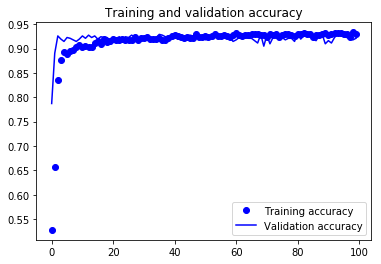

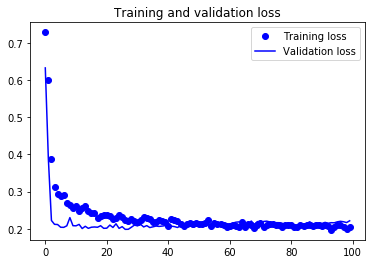

In [189]:
# Plot the training accuracy
accuracy = model_train.history['acc']
val_accuracy = model_train.history['val_acc']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [190]:
model.load_weights("save_best.hdf5")
y_pred = np.argmax(model.predict(valid_X), axis=1)
y_true = np.argmax(valid_label, axis = 1)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
f1 = f1_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
auc = roc_auc_score(y_true, y_pred, average='macro', sample_weight=None, max_fpr=None)
sensi = tp/(tp+fn)
specificity = tn/(tn+fp)
accu = (tn + tp)/(tn + tp + fn + fp)
mcc = ((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))

print('Accuracy :', accu)
print('AUC :', auc)
print('F1 :', f1)
print('Sensitivity :', sensi)
print('Specificity :', specificity)
print('MCC :', mcc)

Accuracy : 0.9274193548387096
AUC : 0.9269977906540497
F1 : 0.9306625577812019
Sensitivity : 0.937888198757764
Specificity : 0.9161073825503355
MCC : 0.8546415538164162
